# 4 - Sísmica de refração

Na aula anterior ([3. Refração crítica](3-refracao-critica.ipynb)), vimos o que acontece quando uma onda P incide sobre uma interface no ângulo crítico. A onda que refrata a 90° possui algumas características diferentes das ondas refletida e direta. A sísmica de refração é um método que utiliza essa características para estimar a profundidade da interface e as velocidades dos meios.

Utilizaremos as simulações de ondas da biblioteca [Fatiando a Terra](http://www.fatiando.org). Essas simulações utilizam o [método de diferenças finitas](http://en.wikipedia.org/wiki/Finite_difference_method) para calcular soluções da equação da onda.

## Objetivos

* Visualizar como seria um dado sísmico de refração (simulado).
* Observar os diversos caminhos que a onda faz para chegar nos receptores e como essas chegadas aparecem nos dados.
* Aprender como usar as medições de primeira chegada para calcular a profundidade da interface e as velocidades.

## Questão para entregar

<div class="alert alert-info" style="font-size:12pt; margin-top:20px">
<b>Explique como funciona a sísmica de refração.</b>
<p>
Sua resposta deve conter no mínimo:
</p>
<ul>
    <li>Como são dispostos os receptores e a fonte.</li>
    <li>Quais são as considerações que devem ser feitas para a escolha da disposição dos receptores (e as fórmulas relevantes).</li>
    <li>O que é medido e qual parte do dado nos interessa.</li>
    <li>Como utilizamos essas medições para extrair as informações do meio (sim, eu quero fórmulas).</li>
    <li>Quais são as limitações do método.</li>
</ul>
</div>

### Regras para a resposta

* Coloque **nome, data e o número da prática** em sua resposta. 
* A resposta pode ter no **máximo 1 página** (não uma folha).
* **Execute o notebook** antes de responder. As simulações abaixo foram feitas para te ajudar.
* **Pense e organize** sua resposta andtes de começar a escrever.

## Instruções

Esse documento é um [Jupyter notebook](http://jupyter.org/), um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (números, texto, figuras, videos, etc).

O notebook te fornecerá exemplos interativos que trabalham os temas abordados no questionário. Utilize esses exemplos para responder as perguntas.

As células com números ao lado, como `In [1]:`, são código [Python](http://python.org/). Algumas dessas células não produzem resultado e servem de preparação para os exemplos interativos. Outras, produzem gráficos interativos. **Você deve executar todas as células, uma de cada vez**, mesmo as que não produzem gráficos.

**Para executar uma célula**, clique em cima dela e aperte `Shift + Enter`. O foco (contorno verde ou cinza em torno da célula) deverá passar para a célula abaixo. Para rodá-la, aperte `Shift + Enter` novamente e assim por diante. Você pode executar células de texto que não acontecerá nada.

## Setup

Rode as células abaixo para carregar os módulos necessários para essa prática.

In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import ipywidgets as ipw
from fatiando.seismic import RickerWavelet, FDAcoustic2D
from fatiando.vis import anim_to_html

/home/leo/miniconda3/envs/geofisica2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Geração de dados sintéticos

Vamos utilizar as simulações de onda P para gerar dados sintéticos. Dessa vez também vamos ignorar as ondas S para não complicar a vida mais do que o necessário. 

O nosso modelo será uma interface plana separando a crosta do manto (a **Moho**).

In [2]:
shape = (300, 1000)
spacing = 400
extent = [0, shape[1]*spacing, shape[0]*spacing, 0]
density = np.zeros(shape, dtype='float32') + 2700
velocity = np.zeros(shape, dtype='float32') + 6000
interface = 100
density[interface:,:] = 3200
velocity[interface:,:] = 8000

A fonte será uma explosão na superfície com as seguintes coordenadas:

In [3]:
fonte = (0, 100)
print('Coordenadas da fonte:')
print('  x = {} m'.format(fonte[1]*spacing))
print('  z = {} m'.format(fonte[0]*spacing))

Coordenadas da fonte:
  x = 40000 m
  z = 0 m


Agora vamos criar o nosso simulador de ondas P com uma fonte explosiva na superfície do nosso modelo.

In [4]:
simul = FDAcoustic2D(velocity, density, spacing=spacing, taper=0.003, padding=80)
simul.add_point_source(fonte, RickerWavelet(1, 4))

In [5]:
simul.run(3000)

[##################################################] | 100% Completed |  1min 56.5s


Rode a célula abaixo para gerar a animação.

In [6]:
simul.animate(every=30, embed=True, dpi=60, cutoff=500, fps=6, cmap='Greys')

Agora vamos fazer a aquisição dos dados usando receptores nas posições mostradas abaixo. Cada receptor irá medir a movimentação do chão ao longo do tempo.

* Os triângulo azuis são os receptores.
* A estrela amarela é a fonte.

In [7]:
receptores = np.arange(fonte[1] + 50, shape[1], 10, dtype='int')

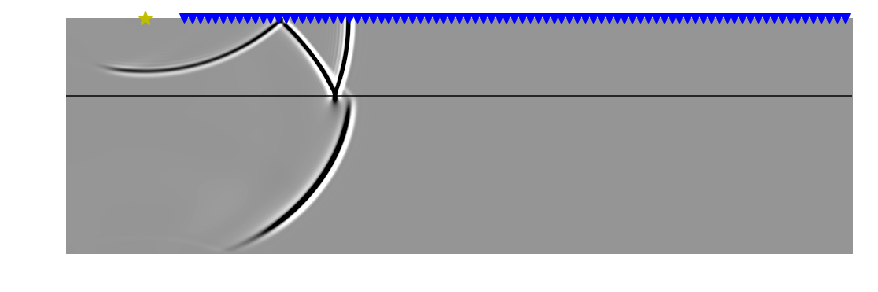

In [8]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(111)
ax.axison = False
ax.imshow(simul[1000], extent=extent, cmap='Greys', vmin=-500, vmax=500)
ax.plot(fonte[1]*spacing, 0, '*y', markersize=15)
ax.plot(receptores*spacing, np.zeros_like(receptores), 'vb', markersize=10)
ax.hlines(interface*spacing, 0, shape[1]*spacing)
ax.set_xlim(0, shape[1]*spacing)
ax.set_ylim(shape[0]*spacing, -10*spacing)
ax.set_ylabel('Profundidade (m)')
ax.set_xlabel(u'Distância (m)')
plt.tight_layout(pad=0)

Cada receptor irá medir a movimentação do solo. Podemos plotar essa movimentação como função do tempo para cada receptor. Se colocarmos o gráfico de cada receptor um ao lado do outro, formamos uma imagem. A cor branca significa movimentação para baixo e a cor preta movimentação para cima.

A figura interativa abaixo permite que você controle os coeficientes linear e angular de uma reta.

In [9]:
dados = simul[:, 0, receptores]
times = np.linspace(0, simul.dt*simul.simsize, simul.simsize)

def reta(linear, angular):
    x = receptores*spacing
    y_reta = linear + angular*x
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(111)
    ax.pcolormesh(x, times, dados, cmap='Greys', vmin=-50, vmax=50)
    ax.plot(x, y_reta, '-b', linewidth=2)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(0, times.max())
    ax.set_ylabel('tempo (s)')
    ax.set_xlabel(u'Distância (m)')

ipw.interactive(reta, 
                linear=ipw.FloatSlider(min=0, max=times.max(), step=0.5, value=5, description='coef. linear (s)'),
                angular=ipw.FloatSlider(min=-0.0005, max=0.0005, step=0.00001, value=0.0001,
                                        readout_format='.6f', description='coef. angular (s/m)'))

interactive(children=(FloatSlider(value=5.0, description=u'coef. linear (s)', max=54.5945945945946, step=0.5), FloatSlider(value=0.0001, description=u'coef. angular (s/m)', max=0.0005, min=-0.0005, readout_format=u'.6f', step=1e-05), Output()), _dom_classes=('widget-interact',))

### Para pensar

* Como aparecem nos dados as ondas direta e refratada no ângulo crítico?
* Tente encontrar o ponto onde a refrata ultrapassa a direta.
* Você pode usar a reta azul para achar os coeficientes angular (em s/m) e linear (em s) de eventos no dado.
* Tente usar os valores obtidos com a reta azul para calcular V1 (de cima), V2 (de baixo) e a profundidade da interface (Moho).

## License and information

**Course website**: https://github.com/leouieda/geofisica2

**Note**: This notebook is part of the course "Geofísica 2" of Geology program of the 
[Universidade do Estado do Rio de Janeiro](http://www.uerj.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)